<a href="https://colab.research.google.com/github/peasantxuan/prediction_fondation_model/blob/main/FoundationModels_TimeGPT_Timesfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Using the influcast dataset to run and assess performance of time series foundation models (TimesFM, TimeGPT)***

###  TIME GPT
#### Refer https://docs.nixtla.io/docs/getting-started-timegpt_quickstart
#### Refer https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/getting-started/2_quickstart.ipynb


In [ ]:
### CREATE ENVIRONMENT FOR TIME GPT
!pip install -Uqq nixtla
from nixtla.utils import in_colab
IN_COLAB = in_colab()
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/getting-started/2_quickstart')


from nixtla import NixtlaClient

# Place to apply API: https://dashboard.nixtla.io/sign_in
nixtla_client = NixtlaClient(
    api_key = 'nixak-Iznn5vuEMWjCHYTSzbBesClgqtGMgMGa7UyJ4VGcw1yXi3XdKfXK4XhsoW8SQwQmFq6QdoJUi7xQBz8a'
)
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()


nixtla_client.validate_api_key()

ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


True

### TIMESFM

### Refer https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/TimesFM%20-%20Time%20Series%20Foundation%20Model.ipynb

In [ ]:
#PREPARE ENVIRONMENT FOR TIMESFM
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.51.0'),
    ('timesfm', 'timesfm'),
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)



project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import timesfm
import numpy as np
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt


bq = bigquery.Client(project = PROJECT_ID)



Are you sure you wish to set property [core/project] to statmike-mlops-349915?

Do you want to continue (Y/n)?  Y

Updated property [core/project].
Colab authorized to GCP


In [ ]:
# Deploy the basic tool of tfm
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=200, # Set this to the number of future time steps you want to predict
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.35k [00:00<?, ?B/s]

### Get five data set (Dengue, Chickenpox...), and basic function for prediction

In [ ]:
# prompt: Get this csv file from dropbox: https://www.dropbox.com/scl/fi/9x3wgar4ky4o2exc7kosl/Dengue_Brazil_1980_2022.csv?rlkey=po2ig1g7msjknnb2p7o705egk&st=wo6ajcmp&dl=0. Give me a more simple one, less include new variable

import pandas as pd
import requests
from io import StringIO  # Make sure StringIO is imported


def get_dengue_data_from_dropbox():
    url = "https://www.dropbox.com/scl/fi/9x3wgar4ky4o2exc7kosl/Dengue_Brazil_1980_2022.csv?rlkey=po2ig1g7msjknnb2p7o705egk&st=gz3xp47x&dl=1"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error if request fails
        df = pd.read_csv(StringIO(response.text), on_bad_lines='skip', delimiter=None)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

dengue_data = get_dengue_data_from_dropbox()


def get_chickenpox_data_from_dropbox():
    url = "https://www.dropbox.com/scl/fi/rea28y2tizeohb8w88g1r/sentinelle_Chickenpox_France_1990_2025.csv?rlkey=rl0j8h528l4tgx7yxrjjmsth2&st=uteetgdz&dl=1"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error if request fails
        df = pd.read_csv(StringIO(response.text), on_bad_lines='skip', delimiter=None)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

chickenpox_data = get_chickenpox_data_from_dropbox()


def get_flu_data_from_dropbox():
    url = "https://www.dropbox.com/scl/fi/cf1j1vi7kfwsey3dxn5ks/sentinelle_Flu_France_2013_2025.csv?rlkey=f2ng6vw8yjx3w66noxk62ndqm&st=y2eexdfx&dl=1"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error if request fails
        df = pd.read_csv(StringIO(response.text), on_bad_lines='skip', delimiter=None)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

flu_data = get_flu_data_from_dropbox()




def get_ILI_data_from_dropbox():
    url = "https://www.dropbox.com/scl/fi/bn8q34o3f0jki4pp8cwkq/sentinelle_ILI_France_1984_2025.csv?rlkey=h57lvdkvvmpoifwprbl6nc4l2&st=s5ptg6t4&dl=1"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error if request fails
        df = pd.read_csv(StringIO(response.text), on_bad_lines='skip', delimiter=None)
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

ILI_data = get_ILI_data_from_dropbox()



def get_RSV_data_from_dropbox():
    url = "https://www.dropbox.com/scl/fi/0cxaw7k9rvqwkwdtiwfi0/sentinelle_RSV_France_2013_2025.csv?rlkey=lh6i42gq7fm8xvry5si56y8y4&st=00bsm9ai&dl=1"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise error if request fails
        df = pd.read_csv(StringIO(response.text), on_bad_lines='skip', delimiter=None,sep =";")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None
RSV_data = get_RSV_data_from_dropbox()

######fill the missing data######

import pandas as pd


def fill_missing_dates_with_previous_inc(df):
    # Sort the DataFrame by date
    df = df.sort_values(by='date')

    # Create a complete 7-day frequency date range between min and max dates
    full_date_range = pd.DataFrame({'date': pd.date_range(start=df['date'].min(),
                                                          end=df['date'].max(),
                                                          freq='7D')})

    # Merge the original DataFrame with the 7-day date range
    df_filled = full_date_range.merge(df, on='date', how='left')

    # Fill missing 'inc' values using the previous available value
    df_filled['inc'] = df_filled['inc'].fillna(method='ffill')

    # Ensure the column order is preserved: ['date', 'inc']
    df_filled = df_filled[['date', 'inc']]

    return df_filled




RSV_data = fill_missing_dates_with_previous_inc(RSV_data)
flu_data = fill_missing_dates_with_previous_inc(flu_data)
ILI_data = fill_missing_dates_with_previous_inc(ILI_data)
chickenpox_data = fill_missing_dates_with_previous_inc(chickenpox_data)
dengue_data = fill_missing_dates_with_previous_inc(dengue_data)



ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
<ipython-input-16-087dfa44e87a>:102: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['inc'] = df_filled['inc'].fillna(method='ffill')
<ipython-input-16-087dfa44e87a>:102: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled['inc'] = df_filled['inc'].fillna(method='ffill')
<ipython-input-16-087dfa44e87a>:102: FutureWarning: Series.fillna with 'method' is deprecated and will raise

In [ ]:
import pandas as pd
import numpy as np
import concurrent.futures

### FUNCTION TO PREDICT BY TIMESGPT
def predict_timegpt(data_name, scenario_name, data, training_date_start, training_date_finish, predict_date_start, predict_date_finish):
    # Calculate the prediction length in days
    predict_length = ((pd.to_datetime(predict_date_finish) - pd.to_datetime(predict_date_start)).days)//7 + 1
    timegpt_forecasts = []

    # Ensure data is sorted by date and filtered for the relevant period
    data = data.sort_values(by='date').copy()

    def forecast_with_timeout():
        return nixtla_client.forecast(
            df=data[(data['date'] >= training_date_start) & (data['date'] <= training_date_finish)],
            h=predict_length,
            freq='W',
            time_col='date',
            target_col='inc'
        )

    for i in range(10):
        print(f"Starting iteration {i + 1}")
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(forecast_with_timeout)
            try:
                # Set a 90-second timeout
                timegpt_fcst_df_predict_test = future.result(timeout=90)
                print(f"Iteration {i + 1} completed successfully.")
            except concurrent.futures.TimeoutError:
                print(f"Iteration {i + 1} timed out. Skipping to the next iteration.")
            except Exception as e:
                print(f"An error occurred in iteration {i + 1}: {e}")
        # Collect the forecasted values
        timegpt_forecasts.append(timegpt_fcst_df_predict_test['TimeGPT'].values)

    # Convert to a NumPy array (100 runs x prediction length)
    timegpt_forecasts = np.array(timegpt_forecasts)

    # Compute the mean, 5th percentile, and 95th percentile
    timegpt_median_forecast = np.median(timegpt_forecasts, axis=0)
    timegpt_lower_bound = np.percentile(timegpt_forecasts, 10, axis=0)
    timegpt_upper_bound = np.percentile(timegpt_forecasts, 90, axis=0)
    # Create a DataFrame for the prediction dates
    training_data = data[(data['date'] >= training_date_start) & (data['date'] < training_date_finish)]
    last_date = training_data['date'].max()
    prediction_dates = pd.date_range(start=last_date, periods=predict_length, freq='7D')


    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'y': timegpt_median_forecast,
        'y_lo': timegpt_lower_bound,
        'y_up': timegpt_upper_bound
    })

    # Merge the original data with the prediction results (on date)
    merged_df = pd.merge(data, prediction_df, on='date', how='left')

    # Fill missing prediction values with NaN (training dates will have NaN in prediction columns)
    merged_df['y'] = merged_df['y'].fillna(np.nan)
    merged_df['y_lo'] = merged_df['y_lo'].fillna(np.nan)
    merged_df['y_up'] = merged_df['y_up'].fillna(np.nan)

    # Add 'dataname' and 'scenario_name' columns
    merged_df['Data'] = data_name
    merged_df['Scenario'] = scenario_name

    # Reorder columns
    merged_df = merged_df[['Data', 'Scenario', 'date', 'inc', 'y', 'y_lo', 'y_up']]

    return merged_df

# Example usage:
# result = predict_timegpt(
#     data_name='Dengue',
#     scenario_name='Scenario_1',
#     data=dengue_data,
#     training_date_start='2015-01-01',
#     training_date_finish='2020-01-01',
#     predict_date_start='2020-01-02',
#     predict_date_finish='2020-07-01'
# )
# print(result)




In [ ]:
### FUNCTION TO PREDICT BY TIMESGPT
def predict_timegpt_pic(data_name, scenario_name, data, training_date_start, training_date_finish, predict_date_start, predict_date_finish):
    # Calculate the prediction length in days
    predict_length = ((pd.to_datetime(predict_date_finish) - pd.to_datetime(predict_date_start)).days) // 7+1

    timegpt_forecasts = []

    # Ensure data is sorted by date and filtered for the relevant period
    data = data.sort_values(by='date').copy()
    def forecast_with_timeout():
        return nixtla_client.forecast(
            df=data[(data['date'] >= training_date_start) & (data['date'] <= training_date_finish)],
            h=predict_length,
            freq='W',
            time_col='date',
            target_col='inc'
        )

    for i in range(10):
        print(f"Starting iteration {i + 1}")
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(forecast_with_timeout)
            try:
                # Set a 90-second timeout
                timegpt_fcst_df_predict_test = future.result(timeout=90)
                print(f"Iteration {i + 1} completed successfully.")
            except concurrent.futures.TimeoutError:
                print(f"Iteration {i + 1} timed out. Skipping to the next iteration.")
            except Exception as e:
                print(f"An error occurred in iteration {i + 1}: {e}")

        # Collect the forecasted values
        timegpt_forecasts.append(timegpt_fcst_df_predict_test['TimeGPT'].values)


    # Convert to a NumPy array (40 runs x prediction length)
    timegpt_forecasts = np.array(timegpt_forecasts)

    # Compute the mean, 5th percentile, and 95th percentile
    timegpt_median_forecast = np.median(timegpt_forecasts, axis=0)
    timegpt_lower_bound = np.percentile(timegpt_forecasts, 10, axis=0)
    timegpt_upper_bound = np.percentile(timegpt_forecasts, 90, axis=0)

    # Create a DataFrame for the prediction dates
    training_data = data[(data['date'] >= training_date_start) & (data['date'] < training_date_finish)]
    last_date = training_data['date'].max()

    prediction_dates = pd.date_range(start=last_date, periods=predict_length, freq='7D')

    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'y': timegpt_median_forecast,
        'y_lo': timegpt_lower_bound,
        'y_up': timegpt_upper_bound
    })

    # Find the peak prediction and corresponding date
    inc_pic = prediction_df['y'].max()
    inc_pic_lo = prediction_df['y_lo'].max()
    inc_pic_up = prediction_df['y_up'].max()
    date_pic = prediction_df.loc[prediction_df['y'].idxmax(), 'date']

    ### GET the peak of raw data
    data_in_prediction_range = data[(data['date'] >= prediction_dates.min()) & (data['date'] <= prediction_dates.max())]

    if not data_in_prediction_range.empty:
        pic_value_data = data_in_prediction_range['inc'].max()
        pic_time_data = data_in_prediction_range.loc[data_in_prediction_range['inc'].idxmax(), 'date']
    else:
        pic_value_data = None
        pic_time_data = None
    # Return a DataFrame with the requested format
    result_df = pd.DataFrame({
        'Data': [data_name],
        'Scenario': [scenario_name],
        'inc_pic': [inc_pic],
        'inc_pic_lo': [inc_pic_lo],
        'inc_pic_up': [inc_pic_up],
        'date_pic': [date_pic],
        'pic_value_data': [pic_value_data],  # 新增
        'pic_time_data': [pic_time_data]
    })

    return result_df


In [ ]:
 ### PREDICTION FUNCTION BY TIMESFM
 ### FUNCTION TO PREDICT BY TIMESGPT
import pandas as pd
import numpy as np
import timesfm

### FUNCTION TO PREDICT
def predict_timesfm(data_name, scenario_name, data, training_date_start, training_date_finish, predict_date_start, predict_date_finish):
    # Calculate the prediction length in days
    predict_length = ((pd.to_datetime(predict_date_finish) - pd.to_datetime(predict_date_start)).days)//7 +1

    # Ensure data is sorted by date and filtered for the relevant period
    data = data.sort_values(by='date').copy()

    # Filter the training data within the specified period
    training_data = data[(data['date'] >= training_date_start) & (data['date'] < training_date_finish)]

    # Initialize and configure TimesFm model
    tfm = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            backend="gpu",
            per_core_batch_size=32,
            horizon_len=predict_length,
            num_layers=50,
            use_positional_embedding=False,
            context_len=2048,
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
        ),
    )

    # Forecast using the training data
    frequency_input = [1]  # Assuming daily frequency; change if necessary
    point_forecast_FM, experimental_quantile_forecast_FM = tfm.forecast(
        [training_data['inc'].values],
        freq=frequency_input
    )

    # Extract lower and upper bounds (5th and 95th percentiles)
    lower_bound_timesfm = experimental_quantile_forecast_FM[0, :, 0]  # 5th percentile
    upper_bound_timesfm = experimental_quantile_forecast_FM[0, :, 9]  # 95th percentile

    # Create a DataFrame for the prediction dates
    last_date = training_data['date'].max()
    prediction_dates = pd.date_range(start=last_date, periods=predict_length, freq='7D')
    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'y': point_forecast_FM[0],
        'y_lo': lower_bound_timesfm,
        'y_up': upper_bound_timesfm
    })

    # Merge the original data with the prediction results (on date)
    merged_df = pd.merge(data, prediction_df, on='date', how='left')

    # Ensure NaNs for training dates in prediction columns
    merged_df['y'] = merged_df['y'].fillna(np.nan)
    merged_df['y_lo'] = merged_df['y_lo'].fillna(np.nan)
    merged_df['y_up'] = merged_df['y_up'].fillna(np.nan)

    # Add 'dataname' and 'scenario_name' columns
    merged_df['Data'] = data_name
    merged_df['Scenario'] = scenario_name

    # Reorder the columns
    merged_df = merged_df[['Data', 'Scenario', 'date', 'inc', 'y', 'y_lo', 'y_up']]

    return merged_df

# Example usage:
# result = predict_timegpt(
#     data_name='Dengue',
#     scenario_name='Scenario_1',
#     data=dengue_data,
#     training_date_start='2015-01-01',
#     training_date_finish='2020-01-01',
#     predict_date_start='2020-01-02',
#     predict_date_finish='2020-07-01'
# )
# print(result)


In [ ]:
#estimate for pics
def predict_timesfm_pic(data_name, scenario_name, data, training_date_start, training_date_finish, predict_date_start, predict_date_finish):
    # Calculate the prediction length in days
    predict_length = ((pd.to_datetime(predict_date_finish) - pd.to_datetime(predict_date_start)).days)//7 +1

    # Ensure data is sorted by date and filtered for the relevant period
    data = data.sort_values(by='date').copy()

    # Filter the training data within the specified period
    training_data = data[(data['date'] >= training_date_start) & (data['date'] < training_date_finish)]

    # Initialize and configure TimesFm model
    tfm = timesfm.TimesFm(
        hparams=timesfm.TimesFmHparams(
            backend="gpu",
            per_core_batch_size=32,
            horizon_len=predict_length,
            num_layers=50,
            use_positional_embedding=False,
            context_len=2048,
        ),
        checkpoint=timesfm.TimesFmCheckpoint(
            huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
        ),
    )

    # Forecast using the training data
    frequency_input = [1]  # Assuming week frequency; change if necessary
    point_forecast_FM, experimental_quantile_forecast_FM = tfm.forecast(
        [training_data['inc'].values],
        freq=frequency_input
    )

    # Extract lower and upper bounds (5th and 95th percentiles)
    lower_bound_timesfm = experimental_quantile_forecast_FM[0, :, 0]  # 5th percentile
    upper_bound_timesfm = experimental_quantile_forecast_FM[0, :, 9]  # 95th percentile

    # Create a DataFrame for the prediction dates
    last_date = training_data['date'].max()
    prediction_dates = pd.date_range(start=last_date, periods=predict_length, freq='7D')
    prediction_df = pd.DataFrame({
        'date': prediction_dates,
        'y': point_forecast_FM[0],
        'y_lo': lower_bound_timesfm,
        'y_up': upper_bound_timesfm
    })

    # Find the peak prediction and corresponding date
    inc_pic = prediction_df['y'].max()
    inc_pic_lo = prediction_df['y_lo'].max()
    inc_pic_up = prediction_df['y_up'].max()
    date_pic = prediction_df.loc[prediction_df['y'].idxmax(), 'date']

    ### GET the peak of raw data
    data_in_prediction_range = data[(data['date'] >= prediction_dates.min()) & (data['date'] <= prediction_dates.max())]

    if not data_in_prediction_range.empty:
        pic_value_data = data_in_prediction_range['inc'].max()
        pic_time_data = data_in_prediction_range.loc[data_in_prediction_range['inc'].idxmax(), 'date']
    else:
        pic_value_data = None
        pic_time_data = None


    # Return a DataFrame with the requested format
    result_df = pd.DataFrame({
        'Data': [data_name],
        'Scenario': [scenario_name],
        'inc_pic': [inc_pic],
        'inc_pic_lo': [inc_pic_lo],
        'inc_pic_up': [inc_pic_up],
        'date_pic': [date_pic],
        'pic_value_data': [pic_value_data],  # 新增
        'pic_time_data': [pic_time_data]
    })

    return result_df



### NEW CODE FOR BENJAMIN NEW INPUT #####

In [ ]:
import pandas as pd

# Define function to generate predictions
input_data = pd.read_csv("/content/Inputs (2).csv", sep =";")


In [ ]:

# Define function to generate predictions
input_data = pd.read_csv("/content/Inputs (2).csv", sep =";")

# Generate predictions for each scenario
ILI_scenarios_fit_data = input_data[(input_data["Data"] == "ILI") & (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]

# Concatenating all predictions
ILI_predictions_timegpt = [
    predict_timegpt("ILI", row["Scenario"], ILI_data, "1984-10-29",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in ILI_scenarios_fit_data.iterrows()
]
all_predictions_ILI_timegpt = pd.concat(ILI_predictions_timegpt, ignore_index=True)

# Save to CSV
all_predictions_ILI_timegpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_ILI_fit.csv', index=False)

ILI_predictions_timesfm = [
    predict_timesfm("ILI", row["Scenario"], ILI_data, "1984-10-29",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in ILI_scenarios_fit_data.iterrows()
]
all_predictions_ILI_timesfm = pd.concat(ILI_predictions_timesfm, ignore_index=True)

# Save to CSV
all_predictions_ILI_timesfm.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_ILI_fit.csv', index=False)



Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed successfully.
Starting iteration 7
Iteration 7 completed successfully.
Starting iteration 8
Iteration 8 completed successfully.
Starting iteration 9
Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed succe

Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


In [ ]:

# Generate predictions for each scenario
Flu_scenarios_fit_data = input_data[(input_data["Data"] == "Flu") & (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]

# Concatenating all predictions
Flu_predictions_timegpt = [
    predict_timegpt("Flu", row["Scenario"], flu_data, "2013-12-30",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Flu_scenarios_fit_data.iterrows()
]
all_predictions_Flu_timegpt = pd.concat(Flu_predictions_timegpt, ignore_index=True)

# Save to CSV
all_predictions_Flu_timegpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Flu_fit.csv', index=False)

Flu_predictions_timesfm = [
    predict_timesfm("Flu", row["Scenario"], flu_data, "2013-12-30",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Flu_scenarios_fit_data.iterrows()
]
all_predictions_Flu_timesfm = pd.concat(Flu_predictions_timesfm, ignore_index=True)

# Save to CSV
all_predictions_Flu_timesfm.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Flu_fit.csv', index=False)



Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed successfully.
Starting iteration 7
Iteration 7 completed successfully.
Starting iteration 8
Iteration 8 completed successfully.
Starting iteration 9
Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed succe

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

# Generate predictions for each scenario
RSV_scenarios_fit_data = input_data[(input_data["Data"] == "RSV") &
                                    (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]

# Concatenating all predictions for TimeGPT
RSV_predictions_timegpt = [
    predict_timegpt("RSV", row["Scenario"], RSV_data, "2014-10-06",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in RSV_scenarios_fit_data.iterrows()
]
all_predictions_RSV_timegpt = pd.concat(RSV_predictions_timegpt, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_RSV_timegpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_RSV_fit.csv', index=False)

# Concatenating all predictions for TimeSFM
RSV_predictions_timesfm = [
    predict_timesfm("RSV", row["Scenario"], RSV_data, "2014-10-06",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in RSV_scenarios_fit_data.iterrows()
]
all_predictions_RSV_timesfm = pd.concat(RSV_predictions_timesfm, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_RSV_timesfm.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_RSV_fit.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed successfully.
Starting iteration 7
Iteration 7 completed successfully.
Starting iteration 8
Iteration 8 completed successfully.
Starting iteration 9
Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed succe

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Generate predictions for each scenario
Chickenpox_scenarios_fit_data = input_data[(input_data["Data"] == "Chickenpox") &
                                           (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]

# Concatenating all predictions for TimeGPT
Chickenpox_predictions_timegpt = [
    predict_timegpt("Chickenpox", row["Scenario"], chickenpox_data, "1990-12-03",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Chickenpox_scenarios_fit_data.iterrows()
]
all_predictions_Chickenpox_timegpt = pd.concat(Chickenpox_predictions_timegpt, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_Chickenpox_timegpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Chickenpox_fit.csv', index=False)

# Concatenating all predictions for TimeSFM
Chickenpox_predictions_timesfm = [
    predict_timesfm("Chickenpox", row["Scenario"], chickenpox_data, "1990-12-03",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Chickenpox_scenarios_fit_data.iterrows()
]
all_predictions_Chickenpox_timesfm = pd.concat(Chickenpox_predictions_timesfm, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_Chickenpox_timesfm.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Chickenpox_fit.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed successfully.
Starting iteration 7
Iteration 7 completed successfully.
Starting iteration 8
Iteration 8 completed successfully.
Starting iteration 9
Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed succe

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
Dengue_scenarios_fit_data = input_data[(input_data["Data"] == "Dengue") &
                                       (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]


In [ ]:
Dengue_scenarios_fit_data = input_data[(input_data["Data"] == "Dengue") &
                                       (input_data["Scenario"].str.contains("3_seasons|4_weeks", regex=True))]

# Concatenating all predictions for TimeGPT
Dengue_predictions_timegpt = [
    predict_timegpt("Dengue", row["Scenario"], dengue_data, "2015-01-04",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Dengue_scenarios_fit_data.iterrows()
]
all_predictions_Dengue_timegpt = pd.concat(Dengue_predictions_timegpt, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_Dengue_timegpt.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Dengue_fit.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


ERROR:nixtla.nixtla_client:Attempt 5 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


ERROR:nixtla.nixtla_client:Attempt 6 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed successfully.
Starting iteration 7
Iteration 7 completed successfully.
Starting iteration 8
Iteration 8 completed successfully.
Starting iteration 9
Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.
Starting iteration 1
Iteration 1 completed successfully.
Starting iteration 2
Iteration 2 completed successfully.
Starting iteration 3
Iteration 3 completed successfully.
Starting iteration 4
Iteration 4 completed successfully.
Starting iteration 5
Iteration 5 completed successfully.
Starting iteration 6
Iteration 6 completed succe

In [ ]:
# Generate predictions for each scenario

# Concatenating all predictions for TimeSFM
Dengue_predictions_timesfm = [
    predict_timesfm("Dengue", row["Scenario"], dengue_data, "2015-01-04",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Dengue_scenarios_fit_data.iterrows()
]
all_predictions_Dengue_timesfm = pd.concat(Dengue_predictions_timesfm, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_Dengue_timesfm.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Dengue_fit.csv', index=False)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#### GET THE PIC VALUE####


# Generate predictions for each scenario
ILI_scenarios_pic_data = input_data[(input_data["Data"] == "ILI") & (input_data["Scenario"].str.contains("pic", regex=True))]

# Concatenating all predictions
ILI_predictions_timegpt_pic = [
    predict_timegpt_pic("ILI", row["Scenario"], ILI_data, "1984-10-29",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in ILI_scenarios_pic_data.iterrows()
]
all_predictions_ILI_timegpt_pic = pd.concat(ILI_predictions_timegpt_pic, ignore_index=True)

# Save to CSV
all_predictions_ILI_timegpt_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_ILI_pic.csv', index=False)

ILI_predictions_timesfm_pic = [
    predict_timesfm_pic("ILI", row["Scenario"], ILI_data, "1984-10-29",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in ILI_scenarios_pic_data.iterrows()
]
all_predictions_ILI_timesfm_pic = pd.concat(ILI_predictions_timesfm_pic, ignore_index=True)

# Save to CSV
all_predictions_ILI_timesfm_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_ILI_pic.csv', index=False)




Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Generate predictions for each scenario
Flu_scenarios_pic_data = input_data[(input_data["Data"] == "Flu") & (input_data["Scenario"].str.contains("pic", regex=True))]

# Concatenating all predictions for TimeGPT
Flu_predictions_timegpt_pic = [
    predict_timegpt_pic("Flu", row["Scenario"], flu_data, "2013-12-30",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Flu_scenarios_pic_data.iterrows()
]
all_predictions_Flu_timegpt_pic = pd.concat(Flu_predictions_timegpt_pic, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_Flu_timegpt_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Flu_pic.csv', index=False)

# Concatenating all predictions for TimeSFM
Flu_predictions_timesfm_pic = [
    predict_timesfm_pic("Flu", row["Scenario"], flu_data, "2013-12-30",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Flu_scenarios_pic_data.iterrows()
]
all_predictions_Flu_timesfm_pic = pd.concat(Flu_predictions_timesfm_pic, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_Flu_timesfm_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Flu_pic.csv', index=False)




Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 502, body: Could not parse JSON: b'Missing request, possibly due to expiry or cancellation'


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Generate predictions for each scenario
RSV_scenarios_pic_data = input_data[(input_data["Data"] == "RSV") & (input_data["Scenario"].str.contains("pic", regex=True))]

# Concatenating all predictions for TimeGPT
RSV_predictions_timegpt_pic = [
    predict_timegpt_pic("RSV", row["Scenario"], RSV_data, "2014-10-06",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in RSV_scenarios_pic_data.iterrows()
]
all_predictions_RSV_timegpt_pic = pd.concat(RSV_predictions_timegpt_pic, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_RSV_timegpt_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_RSV_pic.csv', index=False)

# Concatenating all predictions for TimeSFM
RSV_predictions_timesfm_pic = [
    predict_timesfm_pic("RSV", row["Scenario"], RSV_data, "2014-10-06",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in RSV_scenarios_pic_data.iterrows()
]
all_predictions_RSV_timesfm_pic = pd.concat(RSV_predictions_timesfm_pic, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_RSV_timesfm_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_RSV_pic.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Generate predictions for each scenario
Chickenpox_scenarios_pic_data = input_data[(input_data["Data"] == "Chickenpox") & (input_data["Scenario"].str.contains("pic", regex=True))]

# Concatenating all predictions for TimeGPT
Chickenpox_predictions_timegpt_pic = [
    predict_timegpt_pic("Chickenpox", row["Scenario"], chickenpox_data, "1990-12-03",
                           row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Chickenpox_scenarios_pic_data.iterrows()
]
all_predictions_Chickenpox_timegpt_pic = pd.concat(Chickenpox_predictions_timegpt_pic, ignore_index=True)

# Save to CSV for TimeGPT
all_predictions_Chickenpox_timegpt_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Chickenpox_pic.csv', index=False)

# Concatenating all predictions for TimeSFM
Chickenpox_predictions_timesfm_pic = [
    predict_timesfm_pic("Chickenpox", row["Scenario"], chickenpox_data, "1990-12-03",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Chickenpox_scenarios_pic_data.iterrows()
]
all_predictions_Chickenpox_timesfm_pic = pd.concat(Chickenpox_predictions_timesfm_pic, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_Chickenpox_timesfm_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Chickenpox_pic.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
Dengue_scenarios_pic_data = input_data[(input_data["Data"] == "Dengue") & (input_data["Scenario"].str.contains("pic", regex=True))]

# Concatenating all predictions for TimeGPT
Dengue_predictions_timegpt_pic = [
    predict_timegpt_pic("Dengue", row["Scenario"], dengue_data, "2015-01-04",
                       row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Dengue_scenarios_pic_data.iterrows()
]
all_predictions_Dengue_timegpt_pic = pd.concat(Dengue_predictions_timegpt_pic, ignore_index=True)
all_predictions_Dengue_timegpt_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timegpt_Dengue_pic.csv', index=False)


Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10


Iteration 10 completed successfully.
Starting iteration 1


Iteration 1 completed successfully.
Starting iteration 2


Iteration 2 completed successfully.
Starting iteration 3


Iteration 3 completed successfully.
Starting iteration 4


Iteration 4 completed successfully.
Starting iteration 5


Iteration 5 completed successfully.
Starting iteration 6


Iteration 6 completed successfully.
Starting iteration 7


Iteration 7 completed successfully.
Starting iteration 8


Iteration 8 completed successfully.
Starting iteration 9


Iteration 9 completed successfully.
Starting iteration 10
Iteration 10 completed successfully.


In [ ]:

# Concatenating all predictions for TimeSFM
Dengue_predictions_timesfm_pic = [
    predict_timesfm_pic("Dengue", row["Scenario"], dengue_data, "2015-01-04",
                    row["dstart_test"], row["dstart_test"], row["dend_test"])
    for _, row in Dengue_scenarios_pic_data.iterrows()
]
all_predictions_Dengue_timesfm_pic = pd.concat(Dengue_predictions_timesfm_pic, ignore_index=True)

# Save to CSV for TimeSFM
all_predictions_Dengue_timesfm_pic.to_csv('/content/drive/MyDrive/Colab Notebooks/Prediction_result/timesfm_Dengue_pic.csv', index=False)


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

### Visualisation & Metric calculation

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

data_sources = {
    "SARIMA": [
        "https://www.dropbox.com/scl/fi/5medgcqcbwhh9vf2h75b7/SARIMA_Chickenpox_pic.csv?rlkey=08uwk3ycaydi3glz70p7wp158&st=srroxrth&dl=1",
        "https://www.dropbox.com/scl/fi/83x6le1f8znc3xdje12nb/SARIMA_Dengue_pic.csv?rlkey=aizbk2ikg1pbhu6ryv8htcg8s&st=2xx1rqj7&dl=1",
        "https://www.dropbox.com/scl/fi/pua628t5v5mdl3o43vzze/SARIMA_Flu_pic.csv?rlkey=yggd56wk8jryq8i6ruj5u9elv&st=u3ee4z32&dl=1",
        "https://www.dropbox.com/scl/fi/w1ew8tefaqsphdegvsq8j/SARIMA_ILI_pic.csv?rlkey=9rtpx3vm2v11tfzhfy2neytpw&st=fj2mxpg5&dl=1",
        "https://www.dropbox.com/scl/fi/15xbrmuiux2u4qsjlq18q/SARIMA_RSV_pic.csv?rlkey=5i9apsi0yoqs24pd1ppspurql&st=52pc1jsq&dl=1"
    ],
    "Prophet": [
        "https://www.dropbox.com/scl/fi/4hbce2wyjzisro0p3zc2k/Prophet_pic_Chickenpox.csv?rlkey=o6323auyi7rsbw4dn4x1q44du&st=p24wm5w2&dl=1",
        "https://www.dropbox.com/scl/fi/w2p6rtv7gnhf2rs8i6bgo/Prophet_pic_Dengue.csv?rlkey=bci91zznodic38h0hufwt6tjq&st=syu56l51&dl=1",
        "https://www.dropbox.com/scl/fi/158xsspt11pcc6g4a3p10/Prophet_Flu_pic.csv?rlkey=o586da2nt7izms81wb0u48sjd&st=qw38qdi2&dl=1",
        "https://www.dropbox.com/scl/fi/cw62xtmx9rpnu0v346c06/Prophet_ILI_pic.csv?rlkey=52r464sjg36htgz6mht291ixu&st=axh3b8dh&dl=1",
        "https://www.dropbox.com/scl/fi/yacjicvaso83vb2rvrgem/Prophet_RSV_pic.csv?rlkey=eyicqoornzrpju9u2isaqtexb&st=g8ona6qe&dl=1"
    ],
    "mpf": [
          "https://www.dropbox.com/scl/fi/fx5qxiloqyvlvei8fdvdr/mpF_pic_Chickenpox.csv?rlkey=ufpaoneeyf0dp6gmr5dgmaver&st=j7axxh3o&dl=1",
          "https://www.dropbox.com/scl/fi/b38iu7a36e5u6ihh8f3gk/mpF_pic_Dengue.csv?rlkey=g6sdr06lyr4f2qqbk3ytnhy6d&st=3559660c&dl=1",
          "https://www.dropbox.com/scl/fi/kulug9syejykc738t6za0/mpF_pic_Flu.csv?rlkey=347zcn7wtzfiwzk94qlhy9scw&st=0u53vhxp&dl=1",
          "https://www.dropbox.com/scl/fi/1sg3wh8gg3cq3qmyb17i6/mpF_pic_ILI.csv?rlkey=3dz9ybs7nw3ixzux90fzn5rbp&st=gjdncmjl&dl=1",
          "https://www.dropbox.com/scl/fi/6uz7erwy3gulsgmpcez28/mpF_pic_RSV.csv?rlkey=zibsi0o4ohn4wrtxgq5srj0ux&st=a8fvn5sy&dl=1"
    ],
    "compartmental_model": [
          "https://www.dropbox.com/scl/fi/s6s4lqnkdzdfepbosnrvk/Compartmental_Chickenpox_pic.csv?rlkey=lgqwj8wb1aopwb13wz9941v0p&st=erp7tcyc&dl=1",
          "https://www.dropbox.com/scl/fi/fzb6s8upqwzuw1xxlzbvx/Compartmental_Dengue_pic.csv?rlkey=4rd82xihdz2x7brtfdivr231s&st=pd9avixv&dl=1",
          "https://www.dropbox.com/scl/fi/17d76hz69b9w0akng6ggv/Compartmental_Flu_pic.csv?rlkey=9u8qffbjcgpopfu2mhes7dnp3&st=1unuea5j&dl=1",
          "https://www.dropbox.com/scl/fi/vyze0lm09vpetk1rk3hxn/Compartmental_ILI_pic.csv?rlkey=4bjc7wgc8jx0218gh834z8nrg&st=5winvl36&dl=1",
          "https://www.dropbox.com/scl/fi/ny83lssndkwau1afd1wn9/Compartmental_RSV_pic.csv?rlkey=wlbwvm0s0b1vwukldirb2csey&st=rmtp906z&dl=1"
    ],

    "TimeGPT": [
    "https://www.dropbox.com/scl/fi/kq9trpzs9gk8nq68anbum/timegpt_Chickenpox_pic.csv?rlkey=u873x5yomzwu9vig9ufx0vqs8&st=csm16yvz&dl=1",
    "https://www.dropbox.com/scl/fi/41zmf9pl1yjiteav6p2k5/timegpt_Dengue_pic.csv?rlkey=gfbfhqka69g7qdtjr1qlnzdyd&st=o5cytl8f&dl=1",
    "https://www.dropbox.com/scl/fi/hoenlsr5gb9p5hzy3qoqq/timegpt_Flu_pic.csv?rlkey=ji6wnhsgswpztob2m9febjy8e&st=t5wihy4h&dl=1",
    "https://www.dropbox.com/scl/fi/2je0mjf2msmn4xd39ssxo/timegpt_ILI_pic.csv?rlkey=w8k50f5w4vwry4r2j1jy7njwy&st=0nposk7t&dl=1",
    "https://www.dropbox.com/scl/fi/3ea4giy55e96co0f45m09/timegpt_RSV_pic.csv?rlkey=09pq5brza11y60lhd2a0opuly&st=qpdkl7pc&dl=1"
    ],
    "TimeSFM": [
    "https://www.dropbox.com/scl/fi/ra0hh6dcnags9bnc4d0fj/timesfm_Chickenpox_pic.csv?rlkey=nbzx3yv1vm0ba6x7gjcm9bwsd&st=2lm2zo1x&dl=1",
    "https://www.dropbox.com/scl/fi/qgmeyc8i4amw9gozh7fq4/timesfm_Dengue_pic.csv?rlkey=9kc4qrrfcy77j0rhw0gsra45l&st=16h4hvbb&dl=1",
    "https://www.dropbox.com/scl/fi/w199z5b9gg8rr6uijjy38/timesfm_Flu_pic.csv?rlkey=4jqry4o0w7i1jr0qk1kewjz44&st=ulptf7r5&dl=1",
    "https://www.dropbox.com/scl/fi/0rzi4hcc6k2amlmtjqoit/timesfm_ILI_pic.csv?rlkey=nj3smwkr5uzpupzem05fv2cfr&st=gk4y594j&dl=1",
    "https://www.dropbox.com/scl/fi/ydtmjchle5d3j9pqboh4b/timesfm_RSV_pic.csv?rlkey=36fwnkktc2dhr3aredwh9fg0h&st=qi50tgp9&dl=1"],
    "tabPFN":[
        "https://www.dropbox.com/scl/fi/k4cd7t2jv4bsqry0wybwh/tabPFN_pic_chickenpox_new.csv?rlkey=0pjaegz96pzcklct62aknd28f&st=42ns8ixh&dl=1",
        "https://www.dropbox.com/scl/fi/gtnimizeiypnd9y2q6gi2/tabPFN_pic_Dengue.csv?rlkey=ihqfr6yybufz298p7ui7xyhl5&st=y56f63n0&dl=1",
        "https://www.dropbox.com/scl/fi/i0lo1c77eohrx4so2sgzg/tabPFN_pic_flu_new.csv?rlkey=52z5v2sfxya7wigs50humwjyy&st=a7lyg0oj&dl=1",
        "https://www.dropbox.com/scl/fi/aj8srd94hw82hiie3117g/tabPFN_pic_ILI.csv?rlkey=41yviiaysojcw1mj3m3qf36kz&st=bjbc699f&dl=1",
        "https://www.dropbox.com/scl/fi/761gdd8mkhdqxb0somt37/tabPFN_pic_rsv.csv?rlkey=7ovxqut0pckjhwsw0szuj15yf&st=4cpidzrk&dl=1"
    ],
    "Chronos":[
        "https://www.dropbox.com/scl/fi/c3yi9liiiowt5c4iswo3w/Chronos_pic_Chickenpox.csv?rlkey=umar3uz2w3vqh8hhqplcwpm8m&st=n6l16f1m&dl=1",
        "https://www.dropbox.com/scl/fi/ltcrdayejmlu2dbdsyap0/Chronos_pic_Dengue.csv?rlkey=r5h50t2kng5xln5q5xi0kg5tk&st=opjgtp29&dl=1",
        "https://www.dropbox.com/scl/fi/x881krx04f9xtv2al6c68/Chronos_pic_Flu.csv?rlkey=92itxb2iaaldq6k45an0kk3k3&st=1y89lu0y&dl=1",
        "https://www.dropbox.com/scl/fi/w1hzt4jvizutygn6hukkb/Chronos_pic_ILI.csv?rlkey=j25pivehbzh6zpt5f8g4kpx44&st=h882ik1b&dl=1",
        "https://www.dropbox.com/scl/fi/46g9e2f0p09pjuf0j62qf/Chronos_pic_RSV.csv?rlkey=b6r78h1xjrlenm5i2cot8o0lw&st=spxvyipi&dl=1"],
   # "LagLlama":[
   #     "https://www.dropbox.com/scl/fi/ti6pl9q1t19gekb0pm62l/LagLlama_pic_Chickenpox.csv?rlkey=tw3wy322e1ecyc7z36weoxzs6&st=0wuh9oeo&dl=1",
   #     "https://www.dropbox.com/scl/fi/aghqfr21rfau3hv3cwgva/LagLlama_pic_Dengue.csv?rlkey=hm6tcksxvino7qzwqar0vdxm3&st=t3ytlf7n&dl=1",
   #     "https://www.dropbox.com/scl/fi/gm63nef5cu5vtg7qi476b/LagLlama_pic_Flu.csv?rlkey=i6t92298l4dnsxgbt5f17nqkd&st=zhtls24m&dl=1",
   #     "https://www.dropbox.com/scl/fi/cf6hl4n6ffqjrrcfucfd0/LagLlama_pic_ILI.csv?rlkey=f1lwh4o6z37p4ageu0gmyq575&st=bed69aro&dl=1",
   #     "https://www.dropbox.com/scl/fi/ke70mg0u3ob4x2ib4xigl/LagLlama_pic_RSV.csv?rlkey=vyj51h3i5bhbs9je8p0tbahh0&st=l91qufsv&dl=1"],
    "LagLlama64":[
        "https://www.dropbox.com/scl/fi/3z3496eoz1leczy4gvav8/LagLlama_pic_Chickenpox_64.csv?rlkey=7rgod500yup31f47gufh4kz9b&st=mq3o9da8&dl=1",
        "https://www.dropbox.com/scl/fi/ihcv7m3h8qudk0k0t889z/LagLlama_pic_Dengue_64.csv?rlkey=pnlieiwnrrs6b8q10c648xarm&st=sdb8cevw&dl=1",
        "https://www.dropbox.com/scl/fi/8lc7bbb9p8llq9xw1h16i/LagLlama_pic_Flu_64.csv?rlkey=ekqnx8ml6y24q9ypnriwi40ua&st=h3mbkykx&dl=1",
        "https://www.dropbox.com/scl/fi/qvmcyp45m39iobsltcgih/LagLlama_pic_ILI_64.csv?rlkey=2g3tsegnujg7cbx6tineex0gr&st=hdn0oujz&dl=1",
        "https://www.dropbox.com/scl/fi/3zs421ohk7il97esnywc0/LagLlama_pic_RSV_64.csv?rlkey=gyo32zxs6neckpmq551p3vrnz&st=fuz2expo&dl=1"]
   # "LagLlama64":[
   #       "https://www.dropbox.com/scl/fi/6mho0kyd2qlw7wzx2hls4/LagLlama_Chickenpox_pic_64_MON.csv?rlkey=keim5mo1dbt2vii3j7iic9gf7&st=ogmo1dny&dl=1",
   #       "https://www.dropbox.com/scl/fi/qhxel4mog427jcqpkyay2/LagLlama_Dengue_pic_64_MON.csv?rlkey=7aunjchgmm0s3rgldkmtjguyx&st=825cayck&dl=1",
   #       "https://www.dropbox.com/scl/fi/ka4oo1zjomyyobi97furh/LagLlama_Flu_pic_64_MON.csv?rlkey=n3on6qlwoa932xy2slwtbigw7&st=fmr0akce&dl=1",
   #       "https://www.dropbox.com/scl/fi/auexbp2r2eaar8ldqs96h/LagLlama_pic_ILI_64_MON.csv?rlkey=ohhpco7py7sz8tix58viuqxfv&st=m9g6q441&dl=1",
   #       "https://www.dropbox.com/scl/fi/d613j7m929edxkdg4995n/LagLlama_pic_RSV_64_MON.csv?rlkey=uxi832ijqwd6xm06w053fol7g&st=bgf4jtme&dl=1"]

    #  "LagLlama128":[
  #      "https://www.dropbox.com/scl/fi/u2f952622kguftfqshyt7/LagLlama_pic_Chickenpox_128.csv?rlkey=a16muj22r9pym8q9t6rv89y0a&st=4cdktol3&dl=1",
  #      "https://www.dropbox.com/scl/fi/3hvhxrfsdynjaum08jdsc/LagLlama_pic_Dengue_128rs.csv?rlkey=b4euzd1ctn07e85ly0lrgts36&st=922zg5tg&dl=1",
  #      "https://www.dropbox.com/scl/fi/6lkg23hz1n0alih33bqvr/LagLlama_pic_Flu_128rs.csv?rlkey=9xw2uti4beck8284hz1vwmavr&st=evkwvgj6&dl=1",
  #      "https://www.dropbox.com/scl/fi/myntvs5owgrstpu44c67i/LagLlama_pic_ILI_128rs.csv?rlkey=0rzaxefyyvcsbkzrfz72z9sxa&st=doy1gjl0&dl=1",
  #      "https://www.dropbox.com/scl/fi/70zf4ajryopx88ct98n5m/LagLlama_pic_RSV_128.csv?rlkey=rc08v0mswaxv3k0x7jjx6iv1c&st=u6cwh5r0&dl=1"],
  #  "LagLlama256":[
  #      "https://www.dropbox.com/scl/fi/84y7gjrneu2r2gi1au5c9/LagLlama_pic_Chickenpox_256.csv?rlkey=h9yj7nca2exi4ii6ldfvfrca6&st=j1rn54x9&dl=1",
  #      "https://www.dropbox.com/scl/fi/a79iztjz2tu99z3mjm2et/LagLlama_pic_Dengue_256rs.csv?rlkey=psfgfzjk1w2rghzlrbmijd0bx&st=zmkrl0hr&dl=1",
  #      "https://www.dropbox.com/scl/fi/lm3br6ga45stwv6g1hnce/LagLlama_pic_Flu_256rs.csv?rlkey=3nndk489epqyqanuh3898nkin&st=u58vk2nz&dl=1",
  #      "https://www.dropbox.com/scl/fi/5jdeol1j0hum429uw0q7b/LagLlama_pic_ILI_256rs.csv?rlkey=iw2aycr59vy78kmmafg8j781z&st=4hta4bex&dl=1",
  #      "https://www.dropbox.com/scl/fi/ldq0bvcaw97hbkycgku9q/LagLlama_pic_RSV_256rs.csv?rlkey=2z5q6djpkrizg378aa6lih6wf&st=j8syozpa&dl=1"]





}

# Read all files, adding a 'Model' column
dataframes = []
keywords = ["RSV", "ILI", "Dengue", "Flu", "Chickenpox"]

for model, urls in data_sources.items():
    for url in urls:
        temp_df = pd.read_csv(url, sep=None, engine="python")
        temp_df['Model'] = model  # Add model column
        for keyword in keywords:
                if pd.Series(url).str.contains(keyword).any():
                    temp_df['Data'] = keyword
                    break  # Stop checking after the first match

        dataframes.append(temp_df)

# Concatenate all dataframes
all_pic_data = pd.concat(dataframes, ignore_index=True)


# Display the final dataset

# Merge duplicate columns into 'Data' and 'Scenario'
all_pic_data['Data'] = all_pic_data[['Data', 'data']].bfill(axis=1).iloc[:, 0]
#all_pic_data['date_pic'] = all_pic_data[['date_pic', 'timestamp']].bfill(axis=1).iloc[:, 0]
all_pic_data['date_pic'] = all_pic_data[['date_pic', 'date']].bfill(axis=1).iloc[:, 0]
all_pic_data['date_pic'] = all_pic_data[['date_pic', 'datepic']].bfill(axis=1).iloc[:, 0]

#all_pic_data['Scenario'] = all_pic_data[['Scenario', 'scenario']].bfill(axis=1).iloc[:, 0]

# Drop the redundant columns after merging
#all_pic_data = all_pic_data.drop(columns=['data', 'scenario'])
all_pic_data = all_pic_data.drop(columns=['data'])

# Convert 'date_pic' to datetime format
all_pic_data['date_pic'] = pd.to_datetime(all_pic_data['date_pic'], errors='coerce')
all_pic_data = all_pic_data.drop(columns=['Unnamed: 0', 'pic_value_data',"pic_time_data"])


pic_data_truth= pd.DataFrame({'Annee': [2016, 2017, 2018, 2016, 2017, 2018, 2016, 2017, 2018, 2016, 2017, 2018, 2016, 2017, 2018],
                            'Pic_inc': [24790.0, 22278.0, 27912.0, 267276.0, 299114.0, 394286.0, 13770.0, 33255.0, 26632.0, 18988.0, 18769.0, 142057.0, 21702.0, 18819.0, 21449.0],
                            'Pic_date': ['2016-12-26', '2017-12-25', '2019-01-28', '2017-01-16', '2017-12-25', '2019-02-11', '2017-01-16', '2017-12-25', '2019-01-28', '2017-03-19', '2018-04-08', '2019-05-05', '2017-03-20', '2018-03-19', '2019-04-08'],
                            'Data': ['RSV', 'RSV', 'RSV', 'ILI', 'ILI', 'ILI', 'Flu', 'Flu', 'Flu', 'Dengue', 'Dengue', 'Dengue', 'Chickenpox', 'Chickenpox', 'Chickenpox']})

all_pic_data["Year"] = all_pic_data["Scenario"].str.extract(r'(\d{4})$', expand=False).astype(float).astype("Int64")





#### MERGE DATA#####

all_pic_data = all_pic_data.merge(
    pic_data_truth,
    left_on=["Data", "Year"],
    right_on=["Data", "Annee"],
    how="left"
)

# Rename columns as requested
all_pic_data.rename(columns={"Pic_date": "data_pic_date", "Pic_inc": "data_pic_value"}, inplace=True)

# Drop unnecessary columns
all_pic_data.drop(columns=["Annee"], inplace=True, errors='ignore')



legend_names = {
    "pic_01_07": "October",
    "pic_01_08": "November",
    "pic_01_09": "December",
    "pic_01_10": "October",
    "pic_01_11": "November",
    "pic_01_12": "December",
    "pic_15_12":"December15",
    "M4": "4 weeks before actual peak",
    "M3": "3 weeks before actual peak",
    "M2": "2 weeks before actual peak",
    "M1": "1 week before actual peak",
}

# Infer new column from Scenario
all_pic_data["training_time"] = all_pic_data["Scenario"].apply(
    lambda x: next((legend_names[group] for group in legend_names if group in x), "Unknown")
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-dcee37a348fe>:124: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_pic_data['date_pic'] = all_pic_data[['date_pic', 'date']].bfill(axis=1).iloc[:, 0]
<ipython-input-10-dcee37a348fe>:125: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_pic_data['date_pic'] = all_pic_data[['date_pic', 'datepic']].bfill(axis=1).iloc[:, 0]


In [ ]:
all_pic_data.to_csv("all_pic_data.csv", index=False)


In [ ]:
import pandas as pd

# List to store problematic files
problematic_files = []

# Iterate through each file and try reading it
for model, urls in data_sources.items():
    for url in urls:
        try:
            # Attempt to read the CSV file
            temp_df = pd.read_csv(url)
        except Exception as e:
            # If an error occurs, log the file and the error message
            problematic_files.append((url, str(e)))

# Display problematic files
problematic_files


[('https://www.dropbox.com/scl/fi/pn70r0bgaua7ah1stfz0v/Prophet_pic_Chickenpox.csv?rlkey=5nysup1n3wb9o1rrc74ojdd0f&st=p9m88lwp&dl=1',
  'Error tokenizing data. C error: Expected 1 fields in line 4, saw 3\n'),
 ('https://www.dropbox.com/scl/fi/tfsc4msfvofmktp2elkhx/Prophet_pic_Dengue.csv?rlkey=u5zhqd1lez6b5hksilar31vpa&st=jluwlfep&dl=1',
  'Error tokenizing data. C error: Expected 1 fields in line 4, saw 3\n'),
 ('https://www.dropbox.com/scl/fi/efen14grg93h6tsq1ojvf/Prophet_pic_Flu.csv?rlkey=jivnkode7yth1yx3kw298qf1z&st=8732e5g0&dl=1',
  'Error tokenizing data. C error: Expected 1 fields in line 4, saw 3\n'),
 ('https://www.dropbox.com/scl/fi/8ovo9oscijkeoexedtzeo/Prophet_pic_ILI.csv?rlkey=81cqqjzsf4r8gg0ux5kgfq0mz&st=4vf5vila&dl=1',
  'Error tokenizing data. C error: Expected 1 fields in line 4, saw 3\n'),
 ('https://www.dropbox.com/scl/fi/2f4yx3az67mbus3z641v0/Prophet_pic_RSV.csv?rlkey=9a2505g5bzwmyvq544pugjh5s&st=qiw18f7j&dl=1',
  'Error tokenizing data. C error: Expected 1 fields in

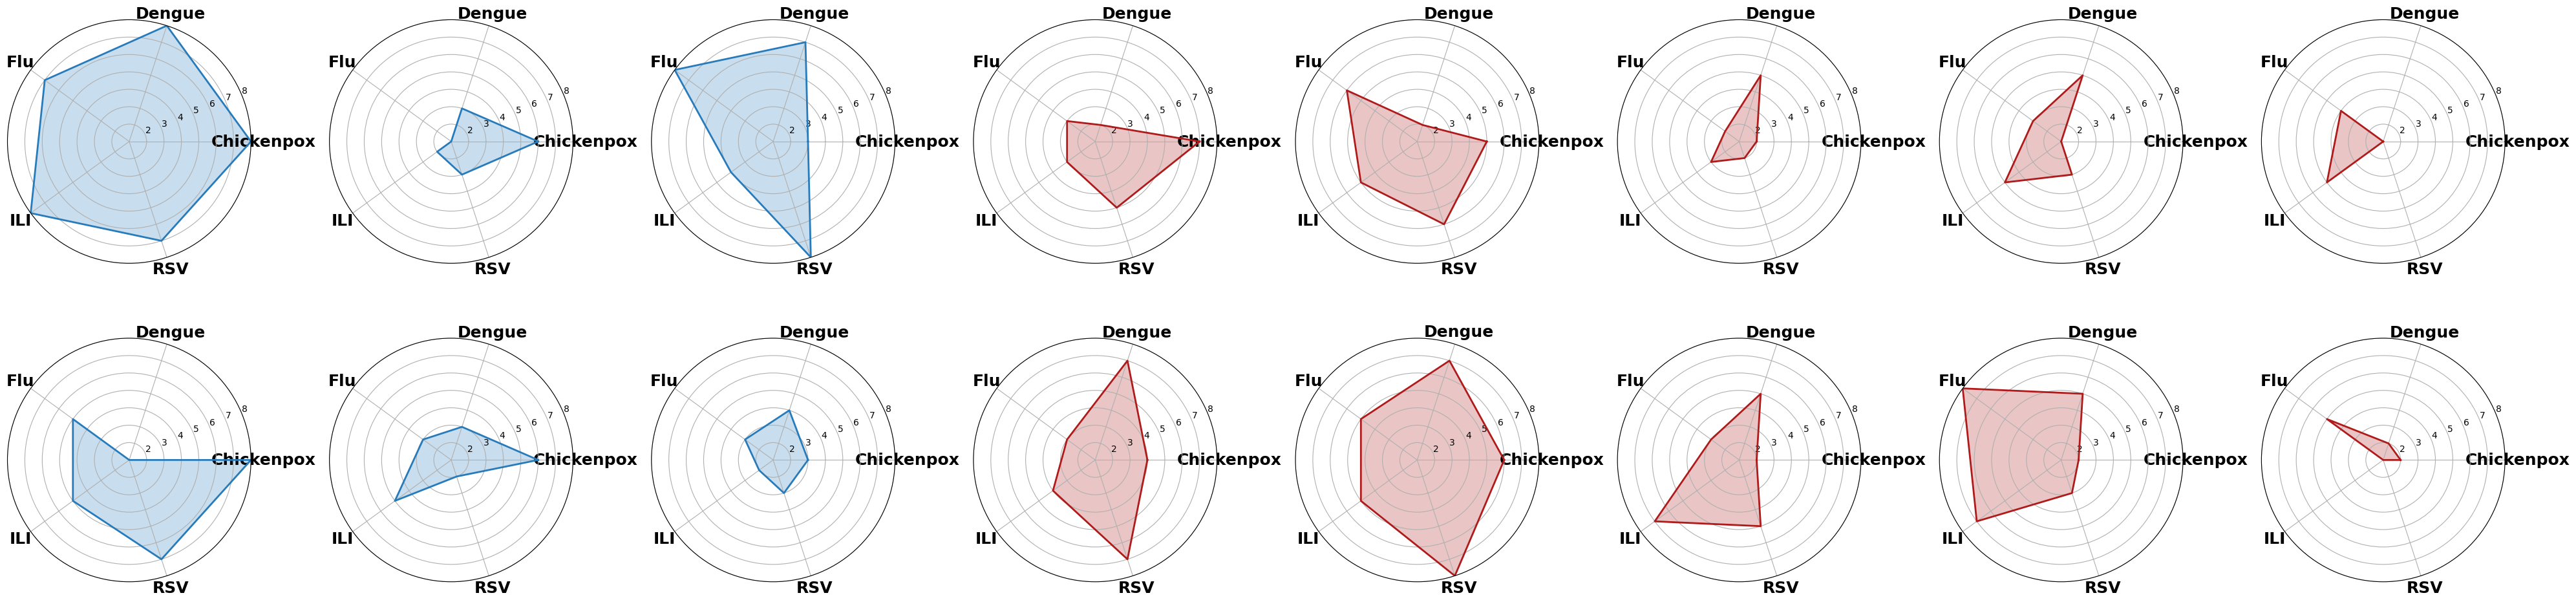

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load the dataset
ranked_data = pd.read_csv("ranked_data.csv")


# Rename columns to match expected structure
ranked_data = ranked_data.rename(columns={
    "Year_Forecast": "Forecast_horizons",
    "Rank": "rank"
})

# Extract relevant columns and drop missing values
ranked_data = ranked_data[['Diseases', 'Forecast_horizons', 'Models', 'rank']].dropna()

# Assign Model_Type based on predefined classification
benchmark_models = ["Mechanistic", "Prophet", "SARIMA"]
foundation_models = ["Lag-Llama", "Chronos", "TimesFM", "TimesGPT", "TabPFN"]

ranked_data["Model_Type"] = ranked_data["Models"].apply(lambda x: "Benchmark Model" if x in benchmark_models else
                                                          ("Foundation Model" if x in foundation_models else "Unknown"))

# Extract the general forecast horizon category (excluding the year component)
ranked_data['General_Forecast_horizon'] = ranked_data['Forecast_horizons'].str.extract(r'(\D+)$')[0]

# Compute the median rank across all years for each Forecast_horizon category
final_median_rank_data = ranked_data.groupby(['Diseases', 'General_Forecast_horizon', 'Models', 'Model_Type'])['rank'].median().reset_index()

# Rename column for clarity
final_median_rank_data = final_median_rank_data.rename(columns={'General_Forecast_horizon': 'Forecast_horizons'})

# Clean the Forecast_horizons values
final_median_rank_data['Forecast_horizons'] = final_median_rank_data['Forecast_horizons'].str.replace('_EARLY', 'EARLY').str.replace('w', '-4w')

# Define fixed colors for model types
model_colors = {
    "Benchmark Model": "#277bbb",
    "Foundation Model": "#af1a1a"
}

# Define the desired order of models
desired_order = ["TabPFN", "TimesGPT", "TimesFM", "Chronos",
                 "Lag-Llama", "SARIMA", "Prophet", "Mechanistic"]

# Reverse the forecast horizon order (rows) and model order (columns)
forecast_horizons = ["EARLY", "-4w"]
models_in_data = [model for model in desired_order if model in final_median_rank_data['Models'].unique()][::-1]
diseases = final_median_rank_data['Diseases'].unique()

# Set up the figure grid: Rows = Forecast horizons (EARLY, -4w), Columns = Models
fig, axes = plt.subplots(len(forecast_horizons), len(models_in_data),
                         figsize=(5 * len(models_in_data), 5 * len(forecast_horizons)),
                         subplot_kw=dict(polar=True))

# Ensure axes are iterable for cases with one row/column
if len(forecast_horizons) == 1:
    axes = [axes]
if len(models_in_data) == 1:
    axes = [[ax] for ax in axes]

# Plot radar chart for each model and forecast horizon
for row, horizon in enumerate(forecast_horizons):
    df_horizon = final_median_rank_data[final_median_rank_data['Forecast_horizons'] == horizon]

    for col, model in enumerate(models_in_data):
        df_model = df_horizon[df_horizon['Models'] == model]

        if df_model.empty:
            axes[row][col].axis('off')  # Hide empty plots
            continue

        # Get model type and corresponding color
        model_type = df_model['Model_Type'].iloc[0]
        color = model_colors.get(model_type, "#000000")  # Default to black if model type not found

        # Get unique axis labels (diseases)
        axis_labels = df_model['Diseases'].unique()

        # Create angle values for radar chart
        num_vars = len(axis_labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Close the radar chart

        ax = axes[row][col]

        # Get values and close the loop
        values = df_model.set_index('Diseases').reindex(axis_labels)['rank'].fillna(0).tolist()
        values += values[:1]  # Close the chart

        # Plot
        ax.plot(angles, values, label=model, color=color, linewidth=2, linestyle='solid')
        ax.fill(angles, values, alpha=0.25, color=color)

        # Adjust radial labels to reflect the actual rank values
        ax.set_ylim(final_median_rank_data['rank'].min(), final_median_rank_data['rank'].max())

        # Add labels with bold and bigger font size for diseases
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(axis_labels, fontsize=18, fontweight='bold')

# Adjust layout and display plot
plt.tight_layout()
plt.show()
